<a href="https://colab.research.google.com/github/rajgit-123/MyProject/blob/master/28_01_2024_Time_Series_Analysis_using_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**yfinance is a popular Python library used for fetching historical market data from Yahoo Finance.**


In [ ]:
# importing yfinance
import yfinance as yf

'AMZN': This is the ticker symbol for Amazon's stock.

period='5y': This parameter specifies the time period.

interval='1d': This sets the data interval. 1d means you want daily data.


In [ ]:
# Collecting data
data_raw = yf.download('AMZN',period='5y',interval='1d')

In [ ]:
# first 5 rows
data_raw.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-14,80.750000,82.410004,79.757500,80.860497,80.860497,120118000
2019-01-15,81.599998,83.758003,81.300499,83.727997,83.727997,119970000
2019-01-16,84.210999,85.250000,83.793999,84.189003,84.189003,127338000
2019-01-17,84.000000,85.008499,83.875000,84.661003,84.661003,84178000
2019-01-18,85.599998,85.809998,84.577003,84.809998,84.809998,120410000


In [ ]:
# last 5 rows
data_raw.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-08,146.740005,149.399994,146.149994,149.100006,149.100006,46757100
2024-01-09,148.330002,151.710007,148.210007,151.369995,151.369995,43812600
2024-01-10,152.059998,154.419998,151.880005,153.729996,153.729996,44421800
2024-01-11,155.039993,157.169998,153.119995,155.179993,155.179993,49072700
2024-01-12,155.389999,156.199997,154.009995,154.619995,154.619995,40460300


In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [ ]:
# Extract Date (index) and Close values into a new DataFrame
data = data_raw[['Close']].copy()
data.reset_index(inplace=True)
data.rename(columns={'index': 'Date'}, inplace=True)

In [ ]:
# Display the new DataFrame
print(data)

           Date       Close
0    2019-01-14   80.860497
1    2019-01-15   83.727997
2    2019-01-16   84.189003
3    2019-01-17   84.661003
4    2019-01-18   84.809998
...         ...         ...
1254 2024-01-08  149.100006
1255 2024-01-09  151.369995
1256 2024-01-10  153.729996
1257 2024-01-11  155.179993
1258 2024-01-12  154.619995

[1259 rows x 2 columns]


In [ ]:
# check for availability of CUDA
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

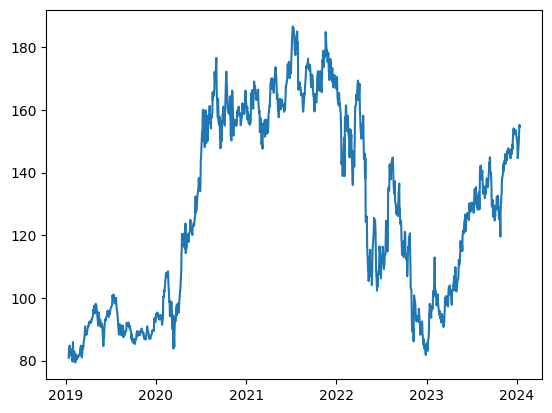

In [ ]:
# Make the data column pandas date type
data['Date'] = pd.to_datetime(data['Date'])

plt.plot(data['Date'], data['Close'])

In [ ]:
# deepcopy is use to create a complete copy of a complex object (like a df),
## including all nested objects. This ensures changes in copy do not affect
### the orginal object
from copy import deepcopy as dc

# custom function to prepare a df for use with an LSTM
## here n_steps = number of time steps to look back in the LSTM model
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    # setting dqate column as index of the dataframe
    df.set_index('Date', inplace=True)

    # this loop iterates iver a range 1 to n_steps
    ## for each iteration it creates a new col in dataframe
    ### new col contains the value from 'i' days ago
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    # removes rows that contain 'NaN' which can occur during shifting operation
    df.dropna(inplace=True)

    return df

lookback = 7

# returns transformed DataFrame suitable for LSTM with additional cols
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
2019-01-24,82.746498,82.000999,81.608498,84.809998,84.661003,84.189003,83.727997,80.860497
2019-01-25,83.528503,82.746498,82.000999,81.608498,84.809998,84.661003,84.189003,83.727997
2019-01-28,81.894501,83.528503,82.746498,82.000999,81.608498,84.809998,84.661003,84.189003
2019-01-29,79.694000,81.894501,83.528503,82.746498,82.000999,81.608498,84.809998,84.661003
2019-01-30,83.521500,79.694000,81.894501,83.528503,82.746498,82.000999,81.608498,84.809998
...,...,...,...,...,...,...,...,...
2024-01-08,149.100006,145.240005,144.570007,148.470001,149.929993,151.940002,153.380005,153.339996
2024-01-09,151.369995,149.100006,145.240005,144.570007,148.470001,149.929993,151.940002,153.380005
2024-01-10,153.729996,151.369995,149.100006,145.240005,144.570007,148.470001,149.929993,151.940002


In [ ]:
# numpy - more efficient storage & computational format for large datasets
shifted_df_as_np = shifted_df.to_numpy()

shifted_df_as_np

array([[ 82.74649811,  82.00099945,  81.60849762, ...,  84.18900299,
         83.72799683,  80.86049652],
       [ 83.52850342,  82.74649811,  82.00099945, ...,  84.66100311,
         84.18900299,  83.72799683],
       [ 81.89450073,  83.52850342,  82.74649811, ...,  84.80999756,
         84.66100311,  84.18900299],
       ...,
       [153.72999573, 151.36999512, 149.1000061 , ..., 148.47000122,
        149.92999268, 151.94000244],
       [155.17999268, 153.72999573, 151.36999512, ..., 144.57000732,
        148.47000122, 149.92999268],
       [154.61999512, 155.17999268, 153.72999573, ..., 145.24000549,
        144.57000732, 148.47000122]])

In [ ]:
shifted_df_as_np.shape

(1252, 8)

In [ ]:
# MinMAxScaler is a tool for scaling features to a specified range
from sklearn.preprocessing import MinMaxScaler

# scaling - improves performance and training stability of ML algos
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.93774709, -0.95166091, -0.95898647, ..., -0.91082451,
        -0.91942863, -0.97294699],
       [-0.92315193, -0.93774709, -0.95166091, ..., -0.90201521,
        -0.91082451, -0.91942863],
       [-0.95364857, -0.92315193, -0.93774709, ..., -0.89923442,
        -0.90201521, -0.91082451],
       ...,
       [ 0.3870725 ,  0.34302599,  0.30065944, ...,  0.28890118,
         0.31615012,  0.35366448],
       [ 0.41413491,  0.3870725 ,  0.34302599, ...,  0.21611259,
         0.28890118,  0.31615012],
       [ 0.40368324,  0.41413491,  0.3870725 , ...,  0.22861729,
         0.21611259,  0.28890118]])

In [ ]:
# guess what is done here
X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((1252, 7), (1252,))

In [ ]:
# Flipping to make t-7 first
X = dc(np.flip(X, axis=1))
X

array([[-0.97294699, -0.91942863, -0.91082451, ..., -0.89923442,
        -0.95898647, -0.95166091],
       [-0.91942863, -0.91082451, -0.90201521, ..., -0.95898647,
        -0.95166091, -0.93774709],
       [-0.91082451, -0.90201521, -0.89923442, ..., -0.95166091,
        -0.93774709, -0.92315193],
       ...,
       [ 0.35366448,  0.31615012,  0.28890118, ...,  0.22861729,
         0.30065944,  0.34302599],
       [ 0.31615012,  0.28890118,  0.21611259, ...,  0.30065944,
         0.34302599,  0.3870725 ],
       [ 0.28890118,  0.21611259,  0.22861729, ...,  0.34302599,
         0.3870725 ,  0.41413491]])

In [ ]:
# Calculate the index for splitting the dataset into train and test sets
split_index = int(len(X) * 0.95)

split_index

1189

In [ ]:
# Splitting the features array into training and testing sets
X_train = X[:split_index]
X_test = X[split_index:]

# Splitting the labels array into training and testing sets
y_train = y[:split_index]
y_test = y[split_index:]

# Display the shapes of the training and testing datasets for features and labels
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1189, 7), (63, 7), (1189,), (63,))

In [ ]:
# Reshape the training and testing feature sets for ML model input
## The data is reshaped to a format of (samples, time steps, features), where
### time steps is the number of previous observations to use for predicting the next observation
X_train = X_train.reshape((-1, lookback, 1))
X_test = X_test.reshape((-1, lookback, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1189, 7, 1), (63, 7, 1), (1189, 1), (63, 1))

In [ ]:
# Convert the training and testing features from NumPy arrays to PyTorch tensors and ensure data type is float
## This is necessary for feeding the data into a PyTorch model
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

# Display the shapes of the PyTorch tensors for training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1189, 7, 1]),
 torch.Size([63, 7, 1]),
 torch.Size([1189, 1]),
 torch.Size([63, 1]))

In [ ]:
# Importing the Dataset class from PyTorch's utility data module,
## basically ensuring compatibility iwth PyTorch data loaders and other utilities
from torch.utils.data import Dataset

# custom func inheriting from PyTorch's Dataset class
## Tailored for handling time series data for model training and testing
class TimeSeriesDataset(Dataset):
    # The constructor initializes the dataset with features (X) and labels (y)
    def __init__(self, X, y):
        self.X = X # Features of the dataset
        self.y = y # Labels of the dataset

    # __len__ method returns the size of the dataset
    def __len__(self):
        return len(self.X) # Number of samples in the dataset

    # __getitem__ method retrieves the ith sample and label from the dataset
    def __getitem__(self, i):
        return self.X[i], self.y[i] # Returns the ith feature and label pair

# Creating instances of the TimeSeriesDataset for training and testing
# These datasets wrap the preprocessed feature and label data (X_train, y_train, X_test, y_test)
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [ ]:
# Display the training dataset object
train_dataset

In [ ]:
from torch.utils.data import DataLoader

# batch size for data loader
batch_size = 16

# Creating DataLoader for the training
# it facilitates the fetching of batches of data and can handle data shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creating a DataLoader for the testing dataset
# For testing, shuffling is typically not necessary, hence shuffle=False
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Creating a DataLoader for the testing dataset
# For testing, shuffling is typically not necessary, hence shuffle=False
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [ ]:
import torch
import torch.nn as nn

# Define a class RNN that inherits from nn.Module
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__() # initializes the base model
        self.hidden_size = hidden_size # size of hidden layers
        self.num_stacked_layers = num_stacked_layers # stacked RNN layers

        # Defining RNN layer, a basic one
        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first=True)

        # FC layer that maps from hidden state space to output space
        self.fc = nn.Linear(hidden_size, 1)

    # forward pass trhough the network
    def forward(self, x):
        # getting batch size
        batch_size = x.size(0)
        # Initializing the hidden state for the first input (with zeros)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        # Passing the input and h0 to the RNN layer
        out, _ = self.rnn(x, h0)  # Note the change here: RNN only needs h0
        out = self.fc(out[:, -1, :]) # Applying the fully connected layer to the last output
        return out

# Example usage
## Creating an instance of the RNN model with specified parameters
model_rnn = RNN(1, 4, 1) # Assuming input_size=1, hidden_size=4, num_stacked_layers=1
model_rnn.to(device)


RNN(
  (rnn): RNN(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
# Define a function to train the model for one epoch
def train_one_epoch():
    # Set the model to training mode
    model_rnn.train(True)

    # Print the current epoch number
    print(f'Epoch: {epoch + 1}')

    # Variable to keep track of the loss for this epoch
    running_loss = 0.0

    # Iterate over each batch in the training data loader
    for batch_index, batch in enumerate(train_loader):
        # Extract features (x_batch) and labels (y_batch) from the batch and move them to the device
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass: compute predicted outputs by passing x_batch to the model
        output = model_rnn(x_batch)

        # Calculate the batch loss using the loss function
        loss = loss_function(output, y_batch)

        # Accumulate the loss
        running_loss += loss.item()

        # Zero out gradients from previous step (this is necessary before backward pass)
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform a single optimization step (parameter update)
        optimizer.step()

        # Print loss every 100 batches
        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1, avg_loss_across_batches))
            running_loss = 0.0

    # Print a new line for neatness
    print()


In [ ]:
# Define a function to validate the model for one epoch
def validate_one_epoch():
    # Set the model to evaluation mode (this will turn off dropout layers, batch normalization, etc.)
    model_rnn.train(False)

    # Variable to keep track of the loss for this validation epoch
    running_loss = 0.0

    # Iterate over each batch in the testing data loader
    for batch_index, batch in enumerate(test_loader):
        # Extract features (x_batch) and labels (y_batch) from the batch and move them to the device
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disable gradient calculations for validation, to save memory and computations
        with torch.no_grad():
            # Forward pass: compute predicted outputs by passing x_batch to the model
            output = model_rnn(x_batch)

            # Calculate the batch loss using the loss function
            loss = loss_function(output, y_batch)

            # Accumulate the loss
            running_loss += loss.item()

    # Calculate the average loss across all batches in the test loader
    avg_loss_across_batches = running_loss / len(test_loader)

    # Print the average validation loss for this epoch
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))

    # Print a separator line for clarity in output
    print('***************************************************')
    print()


In [ ]:
# Set the learning rate for the optimizer
learning_rate = 0.001

# Define the number of epochs for training
num_epochs = 50

# Define the loss function to be used - Mean Squared Error Loss in this case
loss_function = nn.MSELoss()

# Initialize the optimizer (Adam) with the model parameters and set the learning rate
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

# Iterate over the defined number of epochs to train and validate the model
for epoch in range(num_epochs):
    # Call the function to train the model for one epoch
    # This will perform forward and backward passes and update model parameters
    train_one_epoch()

    # Call the function to validate the model for one epoch
    # This will evaluate the model performance on the validation dataset
    validate_one_epoch()


Epoch: 1

Val Loss: 0.101
***************************************************

Epoch: 2

Val Loss: 0.064
***************************************************

Epoch: 3

Val Loss: 0.004
***************************************************

Epoch: 4

Val Loss: 0.008
***************************************************

Epoch: 5

Val Loss: 0.006
***************************************************

Epoch: 6

Val Loss: 0.006
***************************************************

Epoch: 7

Val Loss: 0.005
***************************************************

Epoch: 8

Val Loss: 0.005
***************************************************

Epoch: 9

Val Loss: 0.004
***************************************************

Epoch: 10

Val Loss: 0.005
***************************************************

Epoch: 11

Val Loss: 0.004
***************************************************

Epoch: 12

Val Loss: 0.004
***************************************************

Epoch: 13

Val Loss: 0.004
**********************

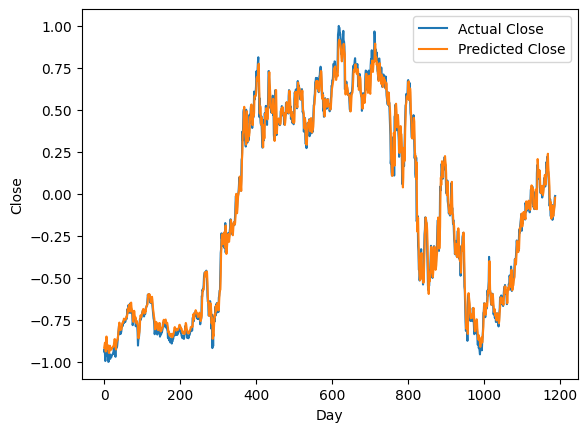

In [ ]:
# Temporarily set all the required gradients to zero (useful for inference)
with torch.no_grad():
    # Forward pass through the RNN model with the training data
    # Then, move the predictions back to the CPU and convert them to a NumPy array
    predicted_rnn = model_rnn(X_train.to(device)).to('cpu').numpy()

# Plotting the actual vs predicted values
plt.plot(y_train, label='Actual Close')  # Plot the actual Close values from the training set
plt.plot(predicted_rnn, label='Predicted Close')  # Plot the predicted Close values by the RNN model

# Setting the labels for the x-axis and y-axis
plt.xlabel('Day')  # Label for the x-axis indicating each point is a day
plt.ylabel('Close')  # Label for the y-axis indicating the Close value

# Adding a legend to distinguish between actual and predicted values
plt.legend()

# Display the plot
plt.show()


In [ ]:
# Flatten the predictions array for easier manipulation
train_predictions_rnn = predicted_rnn.flatten()

# Create a dummy array of zeros with the same number of rows as X_train and 'lookback+1' columns
dummies = np.zeros((X_train.shape[0], lookback+1))

# Place the flattened predictions into the first column of the dummy array
dummies[:, 0] = train_predictions_rnn

# Inverse transform the scaled data to get predictions in the original scale
# Since only the first column of 'dummies' contains meaningful data (predictions), the rest of the columns remain zeros
dummies = scaler.inverse_transform(dummies)

# Extract the first column from the inverse transformed array, which contains the actual predictions
# We use a deep copy to ensure that the original data is not affected by any further modifications
train_predictions_rnn = dc(dummies[:, 0])

# Output the train predictions after inverse scaling
train_predictions_rnn

array([ 83.94683096,  84.78290631,  85.54114401, ..., 128.5933402 ,
       129.59287088, 131.81130433])

In [ ]:
# Create a dummy array of zeros with the same number of rows as X_train and 'lookback+1' columns
# This array is used to inverse transform the scaled target values back to their original scale
dummies = np.zeros((X_train.shape[0], lookback+1))

# Populate the first column of the dummy array with the flattened y_train values
# Flattening is necessary to match the dimensions for the inverse transformation
dummies[:, 0] = y_train.flatten()

# Apply the inverse transformation to the dummy array using the same scaler that was used for scaling the data
# This will transform the target values (y_train) back to their original scale
dummies = scaler.inverse_transform(dummies)

# Extract the first column (which contains the inverse-transformed target values) from the dummy array
# Using deepcopy to ensure that the original data remains unchanged for future use
new_y_train_rnn = dc(dummies[:, 0])

# Output the transformed target values after inverse scaling
new_y_train_rnn


array([ 82.74649658,  83.52850426,  81.89450112, ..., 129.47999582,
       131.83000187, 132.33000184])

# Plotting the actual vs. predicted values for visualization

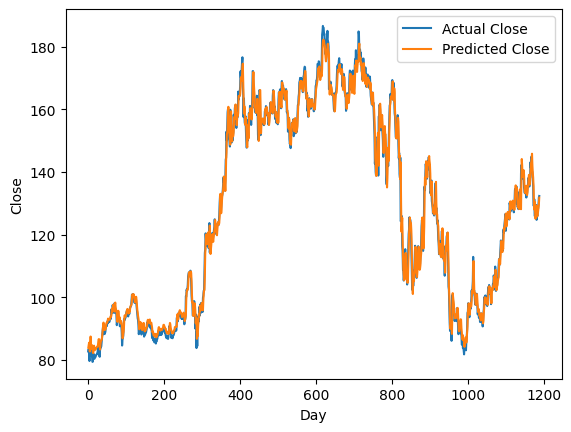

In [ ]:
# Plot the actual Close values from the transformed training set
plt.plot(new_y_train_rnn, label='Actual Close')

# Plot the predicted Close values from the RNN model
plt.plot(train_predictions_rnn, label='Predicted Close')

# Setting the label for the x-axis
plt.xlabel('Day')  # Each point on the x-axis represents a day

# Setting the label for the y-axis
plt.ylabel('Close')  # The y-axis represents the Close value

# Adding a legend to the plot to differentiate between the actual and predicted lines
plt.legend()

# Display the plot on the screen
plt.show()


# Generating predictions for the test dataset using the trained RNN model


In [ ]:
# Forward pass through the model with the test data, detaching gradients, moving to CPU,
# converting to a NumPy array, and then flattening the array
test_predictions_rnn = model_rnn(X_test.to(device)).detach().cpu().numpy().flatten()

# Create a dummy array of zeros with the same number of rows as X_test and 'lookback+1' columns
# This array is used for inverse transforming the scaled predictions back to their original scale
dummies = np.zeros((X_test.shape[0], lookback+1))

# Populate the first column of the dummy array with the test predictions
dummies[:, 0] = test_predictions_rnn

# Apply the inverse transformation to the dummy array using the scaler
# This will transform the predictions back to their original scale
dummies = scaler.inverse_transform(dummies)

# Extract the first column (which contains the inverse-transformed predictions) from the dummy array
# Using deepcopy to ensure that the original dummy data remains unchanged
test_predictions_rnn = dc(dummies[:, 0])

# Output the test predictions after inverse scaling
test_predictions_rnn


array([133.03274283, 130.78076418, 131.77586813, 132.29333061,
       128.91716942, 127.7300841 , 125.71268907, 125.62954525,
       128.25519686, 123.31563867, 118.55035852, 125.25229386,
       133.30010478, 134.75017562, 137.0769592 , 139.15110013,
       139.38133008, 140.12791033, 142.8371864 , 143.29573332,
       141.46414923, 143.14752385, 143.7271458 , 145.59174615,
       144.77284838, 143.15558211, 144.97091556, 146.81314632,
       145.14726066, 146.31317599, 147.61196831, 148.15765585,
       147.85751157, 146.94655265, 146.48860612, 147.25425298,
       145.94903354, 146.62419049, 145.76326492, 146.58028485,
       148.06806574, 146.94925124, 147.41332948, 149.24817503,
       148.52012006, 149.74729666, 153.94353925, 154.96704071,
       153.07484445, 153.6506732 , 154.10115308, 153.80281   ,
       153.73948088, 153.77317337, 152.68451286, 150.62979741,
       148.90088362, 145.58021565, 144.84270602, 148.64270327,
       151.96366266, 154.15589461, 155.72037304])

# Preparing the actual y_test values (target labels) for comparison with model predictions

In [ ]:
# Create a dummy array of zeros with the same number of rows as X_test and 'lookback+1' columns
# This is used for inverse transforming the scaled target values (y_test) back to their original scale
dummies = np.zeros((X_test.shape[0], lookback+1))

# Populate the first column of the dummy array with the flattened y_test values
# Flattening is necessary to match the dimensions for the inverse transformation
dummies[:, 0] = y_test.flatten()

# Apply the inverse transformation to the dummy array using the same scaler that was used for scaling the data
# This will transform the target values (y_test) back to their original scale
dummies = scaler.inverse_transform(dummies)

# Extract the first column (which contains the inverse-transformed target values) from the dummy array
# Using deepcopy to ensure that the original data remains unchanged for future use
new_y_test_rnn = dc(dummies[:, 0])

# Output the transformed target values after inverse scaling
new_y_test_rnn

array([129.78999335, 132.55000303, 131.47000122, 128.13000487,
       128.39999396, 125.16999793, 126.55999752, 128.5599974 ,
       121.38999901, 119.56999891, 127.73999784, 132.71000672,
       133.08999634, 137.00000018, 138.07000726, 138.60000623,
       139.74000588, 142.7100068 , 142.08000179, 140.60000611,
       143.55999748, 142.58999604, 145.80000331, 143.19999713,
       142.8300016 , 145.17999268, 146.13000457, 143.89999391,
       146.71000736, 146.74000486, 147.72999585, 147.02999827,
       146.32000711, 146.08999672, 147.02999827, 144.83999625,
       146.88000437, 144.52000454, 146.88000437, 147.41999772,
       145.88999901, 147.47999591, 148.83999601, 147.41999772,
       149.97000088, 154.07000748, 153.78999408, 152.11999585,
       153.8399963 , 153.41999775, 153.41000337, 153.33999643,
       153.38000427, 151.94000286, 149.92999304, 148.47000128,
       144.57000756, 145.24000525, 149.10000628, 151.36999445,
       153.72999588, 155.17999327, 154.6199952 ])

# Plotting the actual vs. predicted values for the test dataset

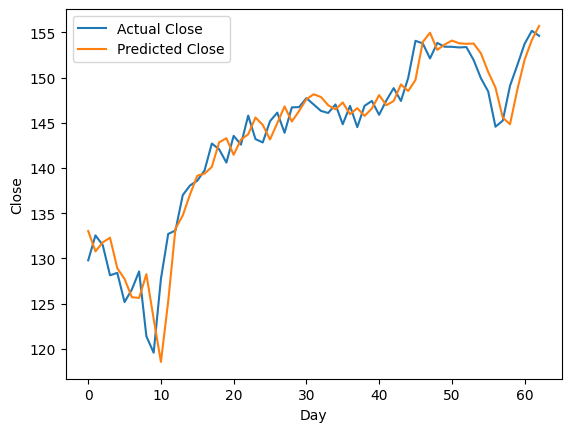

In [ ]:
# Plot the actual Close values from the transformed test dataset (new_y_test_rnn)
plt.plot(new_y_test_rnn, label='Actual Close')  # Label this plot line as 'Actual Close'

# Plot the predicted Close values from the RNN model (test_predictions_rnn)
plt.plot(test_predictions_rnn, label='Predicted Close')  # Label this plot line as 'Predicted Close'

# Setting labels for the axes of the plot
plt.xlabel('Day')  # Label for the x-axis to indicate that each point represents a day
plt.ylabel('Close')  # Label for the y-axis to indicate the 'Close' value of a financial time series

# Adding a legend to the plot for clarity, distinguishing between actual and predicted values
plt.legend()

# Display the plot on the screen
plt.show()




---



---

